# Workflow to analyze the rift catalog
## Brunt - Halloween crack

## import necessary things

In [308]:
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
import matplotlib 
import os
import numpy as np
import rasterio
import pickle
import pandas as pd
import geopandas as gpd
from matplotlib import cm
from netCDF4 import Dataset    
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely.ops import nearest_points
from shapely.geometry import Point, Polygon
from pyproj import Geod
from pyproj import Transformer
from scipy import stats

dataset_path = '/data/fast0/datasets/'
plt.style.use('fivethirtyeight')


## Load GPS data

In [282]:
# Load these now so that we can plot the GPS locations on the map
gps = pd.read_csv(dataset_path + 'bas_marsh_monthly_halloween.csv')

hh00_x = np.array(gps.PSX[ gps.Site=='HH00' ])
hh00_y = np.array(gps.PSY[ gps.Site=='HH00' ])
tt05_x = np.array(gps.PSX[ gps.Site=='TT05' ])
tt05_y = np.array(gps.PSY[ gps.Site=='TT05' ])
ss00_x = np.array(gps.PSX[ gps.Site=='SS00' ])
ss00_y = np.array(gps.PSY[ gps.Site=='SS00' ])
tt04_x = np.array(gps.PSX[ gps.Site=='TT04' ])
tt04_y = np.array(gps.PSY[ gps.Site=='TT04' ])


## Load ITS_LIVE velocities

In [283]:
# This is a good window for all of brunt-riiser-ekstrom
window_x = [-7.7e5,-4.0e5]
window_y = [1.35e6,2e6]

d = Dataset(dataset_path + 'ANT_G0120_0000.nc', 'r')

itslive_x =d.variables['x']
itslive_x = np.array(itslive_x)

itslive_y =d.variables['y']
itslive_y = np.array(itslive_y)

itslive_vx=d.variables['vx']
itslive_vy=d.variables['vy']
itslive_ocean=d.variables['ocean']

x_slice = itslive_x[ (itslive_x<max(window_x)) & (itslive_x>min(window_x)) ]
y_slice = itslive_y[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) ]
xmesh,ymesh = np.meshgrid(x_slice,y_slice)

vx_slice=itslive_vx[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
vy_slice=itslive_vy[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
ocean_slice=itslive_ocean[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
d.close()

# Interpolate.  This will be useful later
from scipy.interpolate import interp2d
vx_interp = interp2d(x_slice, y_slice, vx_slice)
vy_interp = interp2d(x_slice, y_slice, vy_slice)

# Calculate strains
dvx = np.gradient(vx_slice,y_slice,x_slice)
dvy = np.gradient(vx_slice,y_slice,x_slice)

# With this convention:
# dvx[0] is dvx/dy
# dvx[1] is dvx/dx
# dvy[0] is dvy/dy
# dvy[1] is dvy/dx

# Interpolate
vx_x = interp2d(x_slice, y_slice, dvx[1])
vx_y = interp2d(x_slice, y_slice, dvx[0])
vy_x = interp2d(x_slice, y_slice, dvy[1])
vy_y = interp2d(x_slice, y_slice, dvy[0])


## Load rift observations

In [284]:
#rift_obs

shelf_name = 'brunt'

# rift obs
rift_obs_path = '/home/ram21/notebooks/brunt-is2-rifts/' + shelf_name + '_detector_improvements.pkl'
with open(rift_obs_path, 'rb') as handle:
    rift_obs = pickle.load(handle)

# convert to GeoDataFrame 
rift_obs = gpd.GeoDataFrame(rift_obs, geometry=gpd.points_from_xy(rift_obs['x-centroid'], rift_obs['y-centroid']))

#display(rift_obs)

## Halloween crack bounding box

In [285]:
coords = [(-701000,1424000), (-685000,1427500), (-670000,1435000), (-660000,1450000),
         (-655000,1458000),(-685000,1436000),(-703000,1425000)]
poly = Polygon(coords)
box_x,box_y = poly.exterior.xy


## Subset rift_obs to Halloween crack

In [286]:
halloween_obs = rift_obs[rift_obs.within(poly)]

#with open('/home/ram21/notebooks/brunt-is2-rifts/brunt_detector_improvements_halloween.pickle', 'wb') as handle:
#    pickle.dump(halloween_obs, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Merge rift_obs across icebergs/peninsulas/bridges
## using a rift separation of up to 500 m

In [288]:
#display(halloween_obs)

transformer = Transformer.from_crs("EPSG:3031", "EPSG:4326")

#print(len(halloween_obs))

halloween_obs_merged = {
        "d-start": [],
        "d-end": [],
        "x-start": [],
        "y-start": [],
        "x-end": [],
        "y-end": [],
        "x-centroid": [],
        "y-centroid": [],
        "lat-centroid": [],
        "lon-centroid": [],
        "width": [],
        "non-iceberg-width": [],
        "d_seaward": [],
        "d_landward": [],
        "h_seaward": [],
        "h_landward": [],
        "sl_offset": [],        
        "time": [],
        "rgt": [],
        "azimuth": [],
        "sigma": [],
        "h":[],
        "beam":[],
        "data_row":[],
        "confidence":[]
    }

switch = "no"

for i in range(0,len(halloween_obs)-1):
    this_rift_rgt     = halloween_obs["rgt"].iloc[i]
    this_rift_beam    = halloween_obs["beam"].iloc[i]
    this_rift_time    = halloween_obs["time"].iloc[i]
    this_rift_d_end   = halloween_obs["d-end"].iloc[i]
    next_rift_rgt     = halloween_obs["rgt"].iloc[i+1]
    next_rift_beam    = halloween_obs["beam"].iloc[i+1]
    next_rift_time    = halloween_obs["time"].iloc[i+1]
    next_rift_d_start = halloween_obs["d-start"].iloc[i+1]
    
    rift_sep = next_rift_d_start - this_rift_d_end
    
    if (this_rift_rgt == next_rift_rgt) & (this_rift_beam == next_rift_beam) & \
    (this_rift_time == next_rift_time) & (rift_sep < 500):
        halloween_obs_merged["d-start"].append(halloween_obs["d-start"].iloc[i])
        halloween_obs_merged["d-end"].append(halloween_obs["d-end"].iloc[i+1])
        halloween_obs_merged["x-start"].append(halloween_obs["x-start"].iloc[i])
        halloween_obs_merged["y-start"].append(halloween_obs["y-start"].iloc[i])
        halloween_obs_merged["x-end"].append(halloween_obs["x-end"].iloc[i+1])
        halloween_obs_merged["y-end"].append(halloween_obs["y-end"].iloc[i+1])
        halloween_obs_merged["x-centroid"].append((halloween_obs["x-start"].iloc[i]+halloween_obs["x-end"].iloc[i+1])/2)
        halloween_obs_merged["y-centroid"].append((halloween_obs["y-start"].iloc[i]+halloween_obs["y-end"].iloc[i+1])/2)
        [rift_centroid_lat,rift_centroid_lon] = transformer.transform(\
                                            (halloween_obs["x-start"].iloc[i]+halloween_obs["x-end"].iloc[i+1])/2, \
                                            (halloween_obs["y-start"].iloc[i]+halloween_obs["y-end"].iloc[i+1])/2)
        halloween_obs_merged["lat-centroid"].append(rift_centroid_lat)
        halloween_obs_merged["lon-centroid"].append(rift_centroid_lon)
        halloween_obs_merged["width"].append(halloween_obs["d-end"].iloc[i+1]-halloween_obs["d-start"].iloc[i])
        halloween_obs_merged["non-iceberg-width"].append(halloween_obs["width"].iloc[i]+halloween_obs["width"].iloc[i+1])
        halloween_obs_merged["d_seaward"].append(halloween_obs["d_seaward"].iloc[i+1])
        halloween_obs_merged["d_landward"].append(halloween_obs["d_landward"].iloc[i])
        halloween_obs_merged["h_seaward"].append(halloween_obs["h_seaward"].iloc[i+1])
        halloween_obs_merged["h_landward"].append(halloween_obs["h_landward"].iloc[i])
        halloween_obs_merged["sl_offset"].append(halloween_obs["h_seaward"].iloc[i+1] - halloween_obs["h_landward"].iloc[i])
        halloween_obs_merged["time"].append(halloween_obs["time"].iloc[i])
        halloween_obs_merged["rgt"].append(halloween_obs["rgt"].iloc[i])
        halloween_obs_merged["azimuth"].append((halloween_obs["azimuth"].iloc[i]+halloween_obs["azimuth"].iloc[i+1])/2)
        halloween_obs_merged["sigma"].append((halloween_obs["sigma"].iloc[i]+halloween_obs["sigma"].iloc[i+1])/2)
        halloween_obs_merged["h"].append((halloween_obs["h"].iloc[i]+halloween_obs["h"].iloc[i+1])/2)
        halloween_obs_merged["beam"].append(halloween_obs["beam"].iloc[i])
        halloween_obs_merged["data_row"].append(halloween_obs["data_row"].iloc[i])
        halloween_obs_merged["confidence"].append(halloween_obs["confidence"].iloc[i])
        
        switch = "yes"
                
    else:
        
        if switch == "no":
            halloween_obs_merged["d-start"].append(halloween_obs["d-start"].iloc[i])
            halloween_obs_merged["d-end"].append(halloween_obs["d-end"].iloc[i])
            halloween_obs_merged["x-start"].append(halloween_obs["x-start"].iloc[i])
            halloween_obs_merged["y-start"].append(halloween_obs["y-start"].iloc[i])
            halloween_obs_merged["x-end"].append(halloween_obs["x-end"].iloc[i])
            halloween_obs_merged["y-end"].append(halloween_obs["y-end"].iloc[i])
            halloween_obs_merged["x-centroid"].append(halloween_obs["x-centroid"].iloc[i])
            halloween_obs_merged["y-centroid"].append(halloween_obs["y-centroid"].iloc[i])
            halloween_obs_merged["lat-centroid"].append(halloween_obs["lat-centroid"].iloc[i])
            halloween_obs_merged["lon-centroid"].append(halloween_obs["lon-centroid"].iloc[i])
            halloween_obs_merged["width"].append(halloween_obs["width"].iloc[i])
            halloween_obs_merged["non-iceberg-width"].append(halloween_obs["width"].iloc[i])
            halloween_obs_merged["d_seaward"].append(halloween_obs["d_seaward"].iloc[i])
            halloween_obs_merged["d_landward"].append(halloween_obs["d_landward"].iloc[i])
            halloween_obs_merged["h_seaward"].append(halloween_obs["h_seaward"].iloc[i])
            halloween_obs_merged["h_landward"].append(halloween_obs["h_landward"].iloc[i])
            halloween_obs_merged["sl_offset"].append(halloween_obs["sl_offset"].iloc[i])
            halloween_obs_merged["time"].append(halloween_obs["time"].iloc[i])
            halloween_obs_merged["rgt"].append(halloween_obs["rgt"].iloc[i])
            halloween_obs_merged["azimuth"].append(halloween_obs["azimuth"].iloc[i])
            halloween_obs_merged["sigma"].append(halloween_obs["sigma"].iloc[i])
            halloween_obs_merged["h"].append(halloween_obs["h"].iloc[i])
            halloween_obs_merged["beam"].append(halloween_obs["beam"].iloc[i])
            halloween_obs_merged["data_row"].append(halloween_obs["data_row"].iloc[i])
            halloween_obs_merged["confidence"].append(halloween_obs["confidence"].iloc[i])
        switch = "no"

if switch == "no":
    halloween_obs_merged["d-start"].append(halloween_obs["d-start"].iloc[i+1])
    halloween_obs_merged["d-end"].append(halloween_obs["d-end"].iloc[i+1])
    halloween_obs_merged["x-start"].append(halloween_obs["x-start"].iloc[i+1])
    halloween_obs_merged["y-start"].append(halloween_obs["y-start"].iloc[i+1])
    halloween_obs_merged["x-end"].append(halloween_obs["x-end"].iloc[i+1])
    halloween_obs_merged["y-end"].append(halloween_obs["y-end"].iloc[i+1])
    halloween_obs_merged["x-centroid"].append(halloween_obs["x-centroid"].iloc[i+1])
    halloween_obs_merged["y-centroid"].append(halloween_obs["y-centroid"].iloc[i+1])
    halloween_obs_merged["lat-centroid"].append(halloween_obs["lat-centroid"].iloc[i+1])
    halloween_obs_merged["lon-centroid"].append(halloween_obs["lon-centroid"].iloc[i+1])
    halloween_obs_merged["width"].append(halloween_obs["width"].iloc[i+1])
    halloween_obs_merged["non-iceberg-width"].append(halloween_obs["width"].iloc[i+1])
    halloween_obs_merged["d_seaward"].append(halloween_obs["d_seaward"].iloc[i+1])
    halloween_obs_merged["d_landward"].append(halloween_obs["d_landward"].iloc[i+1])
    halloween_obs_merged["h_seaward"].append(halloween_obs["h_seaward"].iloc[i+1])
    halloween_obs_merged["h_landward"].append(halloween_obs["h_landward"].iloc[i+1])
    halloween_obs_merged["sl_offset"].append(halloween_obs["sl_offset"].iloc[i+1])
    halloween_obs_merged["time"].append(halloween_obs["time"].iloc[i+1])
    halloween_obs_merged["rgt"].append(halloween_obs["rgt"].iloc[i+1])
    halloween_obs_merged["azimuth"].append(halloween_obs["azimuth"].iloc[i+1])
    halloween_obs_merged["sigma"].append(halloween_obs["sigma"].iloc[i+1])
    halloween_obs_merged["h"].append(halloween_obs["h"].iloc[i+1])
    halloween_obs_merged["beam"].append(halloween_obs["beam"].iloc[i+1])
    halloween_obs_merged["data_row"].append(halloween_obs["data_row"].iloc[i+1])
    halloween_obs_merged["confidence"].append(halloween_obs["confidence"].iloc[i+1])    
    
halloween_obs_merged = pd.DataFrame(halloween_obs_merged)

# convert to GeoDataFrame 
halloween_obs_merged = gpd.GeoDataFrame(halloween_obs_merged,\
geometry=gpd.points_from_xy(halloween_obs_merged['x-centroid'], halloween_obs_merged['y-centroid']))

#with open('/home/ram21/notebooks/brunt-is2-rifts/brunt_detector_improved_halloween_merged.pickle', 'wb') as handle:
#        pickle.dump(halloween_obs_merged, handle, protocol=pickle.HIGHEST_PROTOCOL)


## Plot just the Halloween crack  against the ITS_LIVE velocities

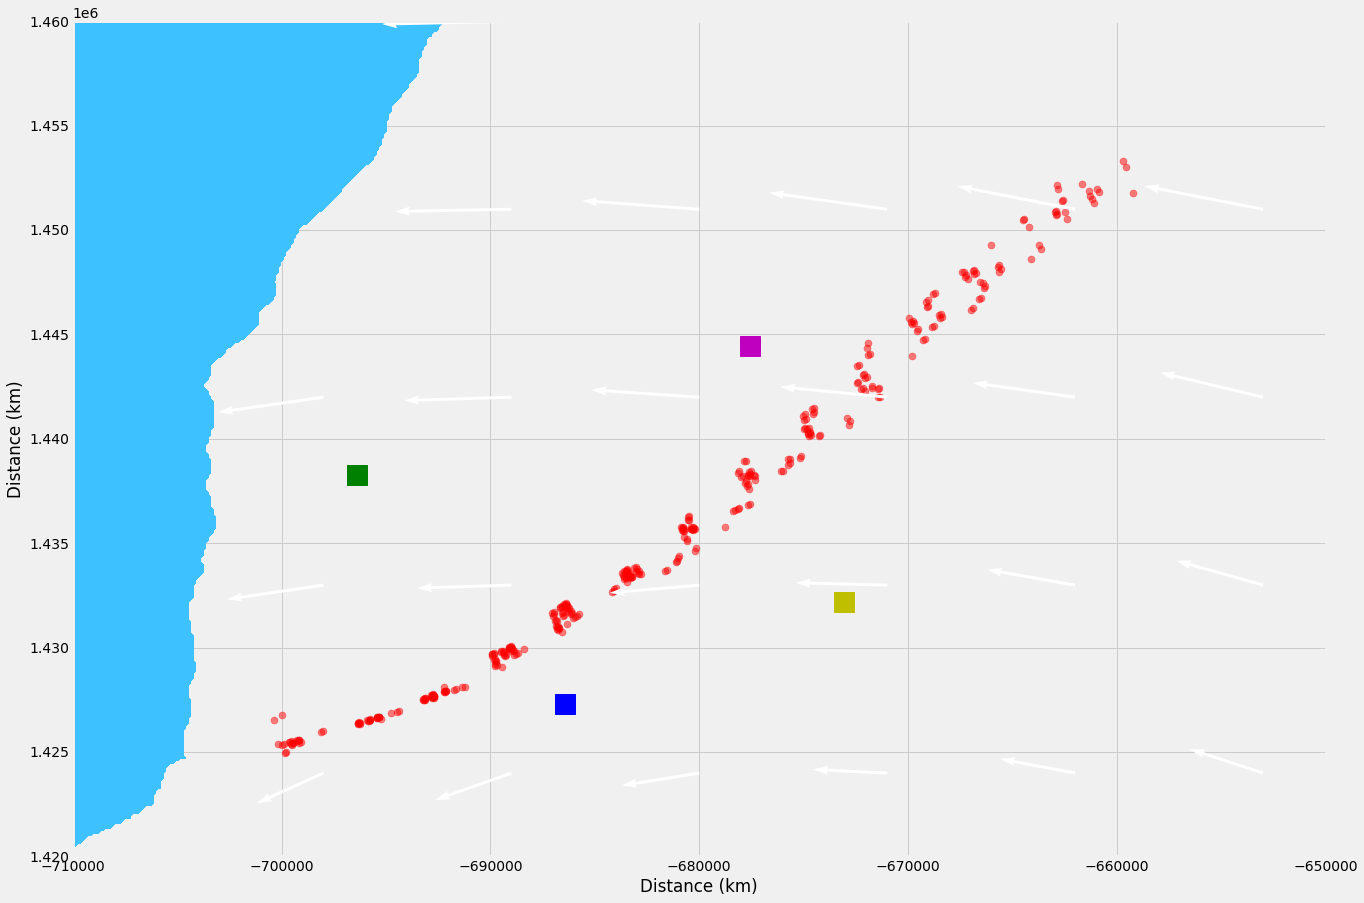

In [289]:
# This is a good window for the Halloween Crack
window_x_halloween = [-7.3e5,-6.4e5]
window_y_halloween = [1.35e6,1.46e6]

fig,ax=plt.subplots(figsize=(20,20))

skip=75
plt.scatter(halloween_obs_merged['x-centroid'] ,halloween_obs_merged['y-centroid'] ,s=50,c='r',alpha=0.5)
plt.contourf(xmesh,ymesh,ocean_slice,cmap=cm.get_cmap('cool',30))

image_file = dataset_path + 'moa125_2014_hp1_v01.tif'
# sat_data = rasterio.open(image_file)
# show(sat_data,cmap="gray",ax=ax3,vmin=0,vmax=1e5)

c = plt.quiver(xmesh[ ::skip, ::skip],
               ymesh[ ::skip, ::skip],
               vx_slice[ ::skip, ::skip], 
               vy_slice[ ::skip, ::skip], scale=9000, color='w')
plt.plot(np.mean(hh00_x),np.mean(hh00_y),'sg',markersize=20)
plt.plot(np.mean(tt05_x),np.mean(tt05_y),'sb',markersize=20)
plt.plot(np.mean(ss00_x),np.mean(ss00_y),'sm',markersize=20)
plt.plot(np.mean(tt04_x),np.mean(tt04_y),'sy',markersize=20)
plt.axis('image')
plt.ylim(window_y_halloween)
plt.xlim(window_x_halloween)
plt.rcParams.update({'font.size': 15})
plt.xlabel('Distance (km)')
plt.ylabel('Distance (km)')
# plt.plot(box_x,box_y)
plt.xlim(-710000,-650000)
plt.ylim(1420000,1460000)

#plt.savefig('./analyze_HC_obs.png', dpi=300, bbox_inches='tight')
plt.show()

## Calculate rift widths and axis angles

A big assumption here is that we already have measured the orientation of the rift.  Ideally, this would be done automatically.  For now, I have just written a script to choose the rift axis manually.

In [290]:
transformer = Transformer.from_crs("EPSG:3031", "EPSG:4326")
geodesic = Geod(ellps='WGS84')

rift_path = pickle.load( open( '/data/fast1/arc/feature_outlines/halloween_path.pickle', "rb" ) )
riftx,rifty = np.array(rift_path.xy)

def estimate_local_rift_orientation(pt,x,y):
    # Given point(x,y), find the two nearest points in approximate_rift_orientation
    # and then return the slope between these two points
    closest = np.argmin( (pt.x-x)**2 + (pt.y-y)**2 )
    if closest > len(x)-2: # We're out of the range of the predefined rift... should probably fix this
        closest = closest-1
    [lat1,long1] = transformer.transform( x[closest] , y[closest] )
    [lat2,long2] = transformer.transform( x[closest+1] ,  y[closest+1] )
    fwd_azimuth,back_azimuth,distance = geodesic.inv(long1, lat1, long2, lat2)
    return fwd_azimuth

def estimate_local_rift_orientation_xy(pt,x,y):
    # Given point(x,y), find the two nearest points in approximate_rift_orientation
    # and then return the slope between these two points
    closest = np.argmin( (pt.x-x)**2 + (pt.y-y)**2 )
    if closest > len(x)-2: # We're out of the range of the predefined rift... should probably fix this
        closest = closest-1
    dx = x[closest+1] - x[closest]
    dy = y[closest+1] - y[closest]
    fwd_azimuth = np.arctan2(dy,dx) * 180/np.pi
#     print('%f, %f, %f'%(dx,dy,fwd_azimuth))
    return fwd_azimuth


# Next step:  estimate actual rift widths for all obs
# This just involves doing a little bit of trigonometry
azimuth = []
azimuth_xy = []
for index, row in halloween_obs_merged.iterrows():
    azimuth.append(estimate_local_rift_orientation(row['geometry'],riftx,rifty))
    azimuth_xy.append(estimate_local_rift_orientation_xy(row['geometry'],riftx,rifty))
actual_width = np.abs(np.sin(np.deg2rad(azimuth - halloween_obs_merged['azimuth']))) * halloween_obs_merged['width']
actual_non_iceberg_width = np.abs(np.sin(np.deg2rad(azimuth - halloween_obs_merged['azimuth']))) * halloween_obs_merged['non-iceberg-width']

# These are the angles of the rift axis
halloween_obs_merged['rift-angle'] = pd.Series(np.array(azimuth), index=halloween_obs_merged.index)
halloween_obs_merged['rift-angle-xy'] = pd.Series(np.array(azimuth), index=halloween_obs_merged.index)
halloween_obs_merged['actual-width'] = pd.Series(np.array(actual_width), index=halloween_obs_merged.index)
halloween_obs_merged['actual-non-iceberg-width'] = pd.Series(np.array(actual_non_iceberg_width), index=halloween_obs_merged.index)



## Perform advection correction
At each time-step: 1) add new observations, 2) advect old observations, 3) merge observations if they are close enough


In [291]:
time_vector = np.sort(np.unique(halloween_obs_merged.time))
time_diff = np.diff(time_vector)
list_of_state_vectors = []
min_seperation_threshold = 0
seperation_list = []
state_vector = pd.DataFrame({'x':np.array([]),'y':np.array([]),'w':np.array([]),
                             't':np.array([]),'a':np.array([]),'aw':np.array([]),
                             'anibw':np.array([]),'rgtr':np.array([])})

for i,t in enumerate(time_vector):
    new_obs = halloween_obs_merged[halloween_obs_merged['time']==t]
    if i>0:
        dt = time_diff[i-1].total_seconds()/86400/365.25 # time step in years
    else:
        dt = np.inf
    print('%i. Found %i new observations at time %s with dt=%s'%(i,len(new_obs),t,dt))
    

    
    # Update the locations of any previous measurements
    if t > min(time_vector):
        
        vx_new = vx_interp(state_vector['x'],state_vector['y'])
        vy_new = vy_interp(state_vector['x'],state_vector['y'])
        
        # Calculate strain rates
        e11 =  vx_x(state_vector['x'],state_vector['y']) 
        e12 = (  vx_y(state_vector['x'],state_vector['y']) 
              +  vy_x(state_vector['x'],state_vector['y']) ) / 2
        e22 =  vy_y(state_vector['x'],state_vector['y']) 
        
        if state_vector['x'].size > 1:
            vx_new = np.diag( vx_new )
            vy_new = np.diag( vy_new )
            e11 = np.diag ( e11 )
            e12 = np.diag ( e12 )
            e22 = np.diag ( e22 )
        
        # Direction cosines of the rift
        dx1 = np.cos(state_vector['a'] * np.pi / 180 + np.pi/2)
        dx2 = np.sin(state_vector['a']* np.pi / 180 + np.pi/2)
        
        # Total stretch on the rift
        dw = e11 * dx1 * dx1 + e12 * dx1 * dx2 + e12 * dx2 * dx1 + e22 * dx2 * dx2
        
        state_vector['x'] = state_vector['x'] + dt * vx_new
        state_vector['y'] = state_vector['y'] + dt * vy_new
        state_vector['w'] = state_vector['w']* (1 + dt * dw )
        state_vector['aw'] = state_vector['aw']* (1 + dt * dw )
        state_vector['anibw'] = state_vector['anibw']* (1 + dt * dw )
    
    
    # Add new observations
    add_this = new_obs.rename(columns={"x-centroid": "x", "y-centroid": "y", "width": "w", 
                                       "time": "t", "rift-angle-xy": "a", "actual-width": "aw",
                                       "actual-non-iceberg-width": "anibw", "rgt": "rgtr"})
    state_vector = state_vector.append( add_this[["x", "y", "w", "t","a","aw","anibw","rgtr"]] )
    list_of_state_vectors.append(pd.DataFrame(state_vector))


0. Found 1 new observations at time 2018-10-16 17:43:10.150777+00:00 with dt=inf
1. Found 5 new observations at time 2018-10-17 04:36:21.159767+00:00 with dt=0.001241888134395518
2. Found 3 new observations at time 2018-10-21 04:27:52.728882+00:00 with dt=0.010935291945997162
3. Found 6 new observations at time 2018-11-10 16:27:49.994267+00:00 with dt=0.056125854481487825
4. Found 4 new observations at time 2018-11-15 03:12:21.336990+00:00 with dt=0.012176824052621238
5. Found 5 new observations at time 2018-11-19 03:03:53.408036+00:00 with dt=0.010935307851230765
6. Found 2 new observations at time 2018-12-13 14:55:15.840583+00:00 with dt=0.06706094356183612
7. Found 4 new observations at time 2018-12-14 01:48:05.538331+00:00 with dt=0.001241212821887596
8. Found 6 new observations at time 2019-01-07 13:39:44.483041+00:00 with dt=0.06706146680070728
9. Found 2 new observations at time 2019-02-05 12:15:56.432384+00:00 with dt=0.07923834351607854
10. Found 5 new observations at time 201

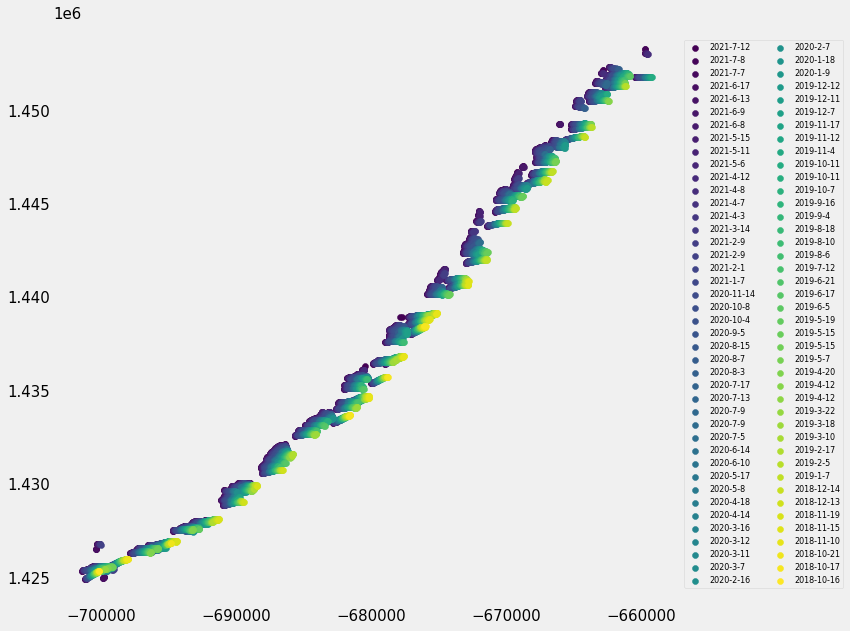

In [292]:
fig,ax = plt.subplots(figsize=(10,10))

color=iter(cm.viridis(np.linspace(0,1,len(list_of_state_vectors))))
for item,t in zip(reversed(list_of_state_vectors),reversed(time_vector)):
    c=next(color)
    plt.scatter(item['x'],item['y'],color=c, label='%i-%i-%i'%(t.year,t.month,t.day))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, prop={'size': 8})
plt.grid()

#plt.savefig('./analyze_HC_advection.png', dpi=300, bbox_inches='tight')
plt.show()

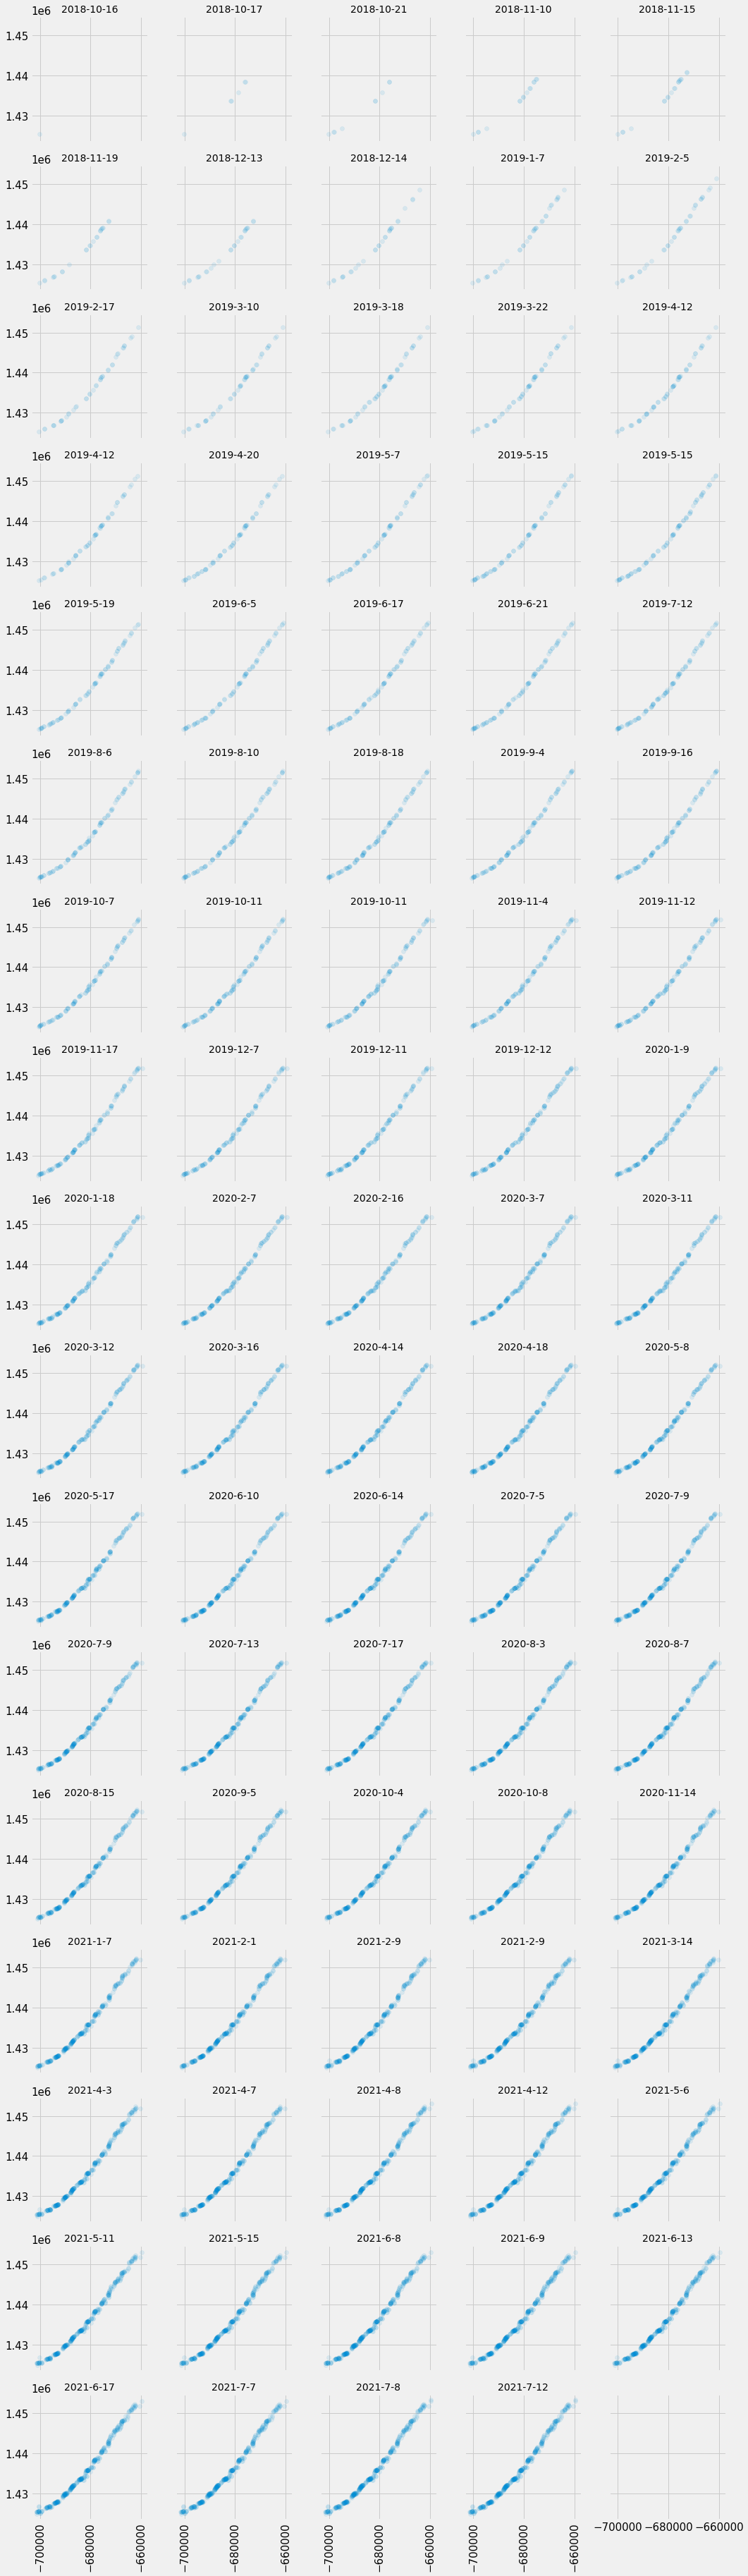

In [293]:
fig,ax = plt.subplots(17, 5,sharex='all', sharey='all',figsize=(15,51))

for item,t,i in zip(list_of_state_vectors,time_vector,np.arange(len(list_of_state_vectors))):
    plt.subplot(17,5,1+i)
    plt.scatter(item['x'],item['y'],alpha=0.1)
    plt.title('%d-%d-%d'%(t.year,t.month,t.day),fontsize=14)
    plt.xticks(rotation = 90)
plt.tight_layout()

#plt.savefig('./analyze_HC_advection2.png', dpi=300, bbox_inches='tight')
plt.show()

In [294]:
latest = list_of_state_vectors[-1]
times = latest['t'].apply(lambda x: (x- latest.iloc[0]['t']).days).values
times_h = halloween_obs_merged['time'].apply(lambda x: (x- latest.iloc[0]['t']).days).values

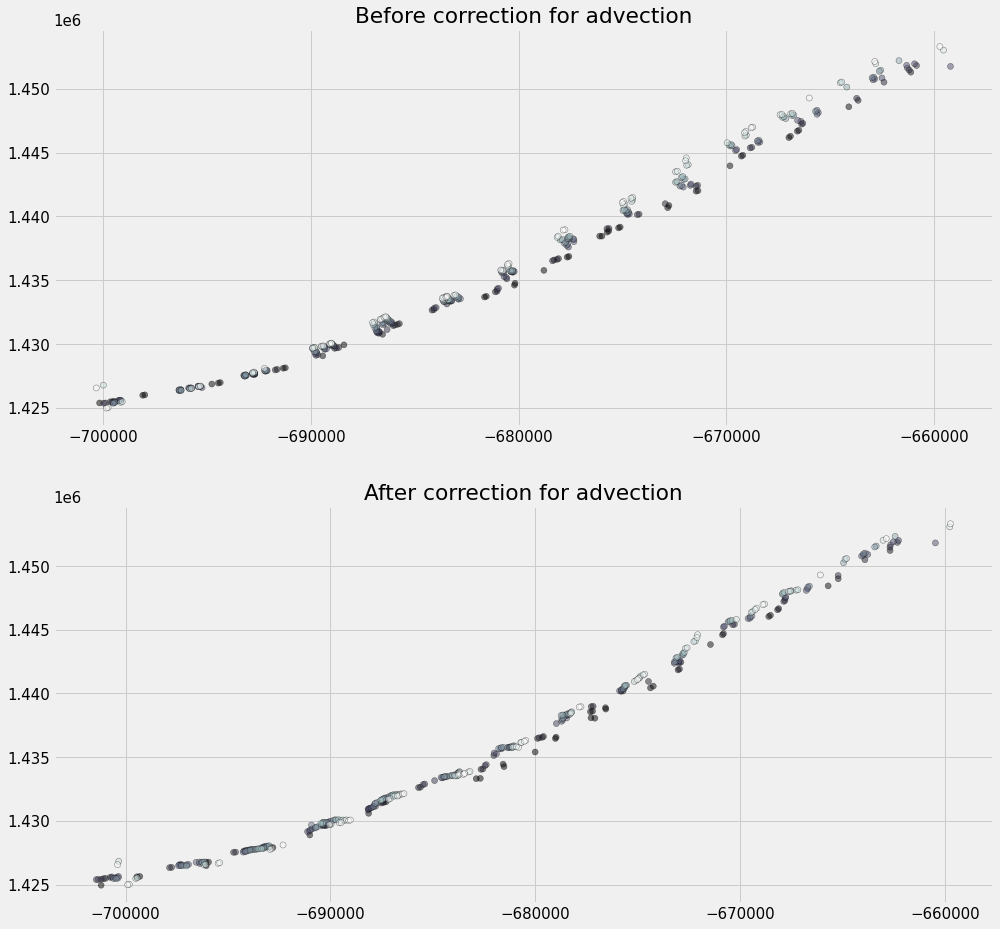

In [295]:
plt.subplots(2,1,figsize=(15,15))

ax=plt.subplot(2,1,1)
c=ax.scatter(halloween_obs_merged['x-centroid'],halloween_obs_merged['y-centroid'],c=times_h,cmap='bone',alpha=0.5,edgecolors='k')
ax.set_title('Before correction for advection')

ax=plt.subplot(2,1,2)
c=ax.scatter(latest['x'],latest['y'],c=times,cmap='bone',alpha=0.5,edgecolors='k')
ax.set_title('After correction for advection')

#plt.savefig('./analyze_HC_advection3.png', dpi=300, bbox_inches='tight')
plt.show()

## Rift measurement from Satellite imagery
rift widths along rgts from Landsat-8 image from 2018-10-14, defining initial rift dimensions at the time of first ICESat-2 observation

In [296]:
LS8_obs_20181014 = {
    "rgt": [1289,1289,\
            718,718,718,718,\
            344,344,344,344,344,344,\
            1160,1160,1160,1160,1160,1160,\
            786,786,786,786,786,786,\
            215,215,215,215,215,215,\
            1228,1228,1228,1228,1228,1228,\
            657,657,657,657,657,657,\
            283,283,283,283,283,283,\
            1099,1099,1099,1099,1099,1099,\
            725,725,725,725,725,725,\
            154,154,154,154,154,154,\
            1167,1167,1167,1167,1167,1167,\
            596,596,596,596,596,596,\
            222,222,\
            1038,1038],
    "laser": ["1l","1r",\
              "2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "3l","3r",\
              "1l","1r"],
    "centroid_lon": [-26.1549,-26.1514,\
                     -26.1256,-26.1290,-25.9999,-26.0032,\
                     -25.9020,-25.8986,-26.0085,-26.0185,-26.1396,-26.1362,\
                     -25.9836,-25.9868,-25.8252,-25.8254,-25.7375,-25.7408,\
                     -25.6424,-25.6389,-25.7653,-25.7619,-25.8869,-25.8834,\
                     -25.7225,-25.7257,-25.6020,-25.6052,-25.4830,-25.4862,\
                     -25.3790,-25.3753,-25.5008,-25.4974,-25.6260,-25.6335,\
                     -25.4672,-25.4705,-25.3338,-25.3518,-25.2304,-25.2336,\
                     -25.1038,-25.1049,-25.2345,-25.2309,-25.3618,-25.3575,\
                     -25.2153,-25.2185,-25.0768,-25.1005,-24.9804,-24.9837,\
                     -24.8342,-24.8305,-24.9651,-24.9614,-25.0904,-25.0868,\
                     -24.9644,-24.9676,-24.8517,-24.8550,-24.7339,-24.7371,\
                     -24.5647,-24.5610,-24.6906,-24.6870,-24.8164,-24.8130,\
                     -24.7176,-24.7208,-24.6007,-24.6040,-24.4847,-24.4879,\
                     -24.5468,-24.5427,\
                     -24.4683,-24.4714],
    "centroid_lat": [-75.4599,-75.4599,\
                     -75.4613,-75.4612,-75.4674,-75.4675,\
                     -75.4703,-75.4702,-75.4667,-75.4672,-75.4607,-75.4608,\
                     -75.4678,-75.4678,-75.4786,-75.4761,-75.4718,-75.4718,\
                     -75.4704,-75.4702,-75.4720,-75.4720,-75.4717,-75.4717,\
                     -75.4708,-75.4710,-75.4686,-75.4689,-75.4641,-75.4642,\
                     -75.4643,-75.4639,-75.4643,-75.4643,-75.4698,-75.4696,\
                     -75.4636,-75.4636,-75.4623,-75.4589,-75.4530,-75.4532,\
                     -75.4456,-75.4455,-75.4532,-75.4529,-75.4619,-75.4606,\
                     -75.4509,-75.4511,-75.4473,-75.4453,-75.4375,-75.4376,\
                     -75.4219,-75.4214,-75.4373,-75.4367,-75.4432,-75.4429,\
                     -75.4372,-75.4374,-75.4230,-75.4231,-75.4172,-75.4174,\
                     -75.4058,-75.4054,-75.4134,-75.4131,-75.4206,-75.4205,\
                     -75.4162,-75.4163,-75.4089,-75.4091,-75.4004,-75.4007,\
                     -75.4041,-75.4031,\
                     -75.3991,-75.3994],
    "total_width": [201,199,\
                    263,271,408,396,\
                    431,432,318,338,216,235,\
                    432,432,632,633,488,482,\
                    456,461,486,475,654,627,\
                    669,654,603,579,422,433,\
                    418,410,430,435,469,502,\
                    404,397,497,483,627,630,\
                    288,303,671,671,622,646,\
                    367,373,265,292,261,269,\
                    289,293,292,392,355,323,\
                    235,265,239,225,165,150,\
                    125,130,232,191,211,214,\
                    185,177,121,132,88,82,\
                    133,198,\
                    75,75],
    "non-iceberg-width": [201,199,\
                    263,271,408,396,\
                    431,432,318,338,216,235,\
                    432,432,447,451,488,482,\
                    456,461,486,475,390,414,\
                    457,444,414,427,422,433,\
                    418,410,430,435,469,502,\
                    404,397,497,483,310,327,\
                    288,303,360,353,622,646,\
                    367,373,265,292,261,269,\
                    289,293,292,272,355,323,\
                    235,265,239,225,165,150,\
                    125,130,232,191,211,214,\
                    185,177,121,132,88,82,\
                    133,143,\
                    75,75],
    "comment": ["-","-",\
                "-","-","-","-",\
                "-","-","-","-","-","-",\
                "-","-","bridge","bridge","-","-",\
                "-","-","-","-","bridge","bridge",\
                "bridge","bridge","bridge","bridge","-","-",\
                "-","-","-","-","-","-",\
                "-","-","-","-","bridge","bridge",\
                "-","-","bridge","bridge","-","-",\
                "-","-","-","-","-","-",\
                "-","-","-","bridge","-","-",\
                "-","-","-","-","-","-",\
                "-","-","-","-","-","-",\
                "-","-","-","-","-","-",\
                "-","bridge",\
                "-","-"],
    "azimuth": [-171.1,-171.1,\
                -8.9,-8.9,-8.9,-8.9,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -171.1,-171.1,\
                -8.9,-8.9]
}
                       
LS8_obs_20181014 = pd.DataFrame(LS8_obs_20181014)
#display(LS8_obs_20181014)


In [297]:
transformer = Transformer.from_crs("EPSG:4326","EPSG:3031")

Ecentroid = []
Ncentroid = []
for index, row in LS8_obs_20181014.iterrows():
    [Ecent,Ncent] = transformer.transform(row["centroid_lat"],row["centroid_lon"])
    Ecentroid.append(Ecent)
    Ncentroid.append(Ncent)

LS8_obs_20181014["x-centroid"] = Ecentroid
LS8_obs_20181014["y-centroid"] = Ncentroid

LS8_obs_20181014 = gpd.GeoDataFrame(LS8_obs_20181014, geometry=gpd.points_from_xy(LS8_obs_20181014["x-centroid"],LS8_obs_20181014["y-centroid"]))

transformer = Transformer.from_crs("EPSG:3031", "EPSG:4326")
geodesic = Geod(ellps='WGS84')

rift_path = pickle.load( open( '/data/fast1/arc/feature_outlines/halloween_path.pickle', "rb" ) )
riftx,rifty = np.array(rift_path.xy)

def estimate_local_rift_orientation(pt,x,y):
    # Given point(x,y), find the two nearest points in approximate_rift_orientation
    # and then return the slope between these two points
    closest = np.argmin( (pt.x-x)**2 + (pt.y-y)**2 )
    if closest > len(x)-2: # We're out of the range of the predefined rift... should probably fix this
        closest = closest-1
    [lat1,long1] = transformer.transform( x[closest] , y[closest] )
    [lat2,long2] = transformer.transform( x[closest+1] ,  y[closest+1] )
    fwd_azimuth,back_azimuth,distance = geodesic.inv(long1, lat1, long2, lat2)
    return fwd_azimuth

def estimate_local_rift_orientation_xy(pt,x,y):
    # Given point(x,y), find the two nearest points in approximate_rift_orientation
    # and then return the slope between these two points
    closest = np.argmin( (pt.x-x)**2 + (pt.y-y)**2 )
    if closest > len(x)-2: # We're out of the range of the predefined rift... should probably fix this
        closest = closest-1
    dx = x[closest+1] - x[closest]
    dy = y[closest+1] - y[closest]
    fwd_azimuth = np.arctan2(dy,dx) * 180/np.pi
#     print('%f, %f, %f'%(dx,dy,fwd_azimuth))
    return fwd_azimuth

azimuth = []
azimuth_xy = []
for index, row in LS8_obs_20181014.iterrows():
    azimuth.append(estimate_local_rift_orientation(row["geometry"],riftx,rifty))
    azimuth_xy.append(estimate_local_rift_orientation_xy(row["geometry"],riftx,rifty))
actual_width = np.abs(np.sin(np.deg2rad(azimuth - LS8_obs_20181014['azimuth']))) * LS8_obs_20181014['total_width']
actual_non_iceberg_width = np.abs(np.sin(np.deg2rad(azimuth - LS8_obs_20181014['azimuth']))) * LS8_obs_20181014['non-iceberg-width']

LS8_obs_20181014['rift-angle'] = pd.Series(np.array(azimuth), index=LS8_obs_20181014.index)
LS8_obs_20181014['rift-angle-xy'] = pd.Series(np.array(azimuth), index=LS8_obs_20181014.index)
LS8_obs_20181014['actual-width'] = pd.Series(np.array(actual_width), index=LS8_obs_20181014.index)
LS8_obs_20181014['actual-non-iceberg-width'] = pd.Series(np.array(actual_non_iceberg_width), index=LS8_obs_20181014.index)

#display(LS8_obs_20181014)


## Calculate the average GPS opening

In [298]:
hh00_t = np.array(gps.YYYY[gps.Site=='HH00' ]) + (np.array(gps.MM[gps.Site=='HH00' ]) / 12) - (15/365)
tt05_t = np.array(gps.YYYY[gps.Site=='TT05' ]) + (np.array(gps.MM[gps.Site=='TT05' ]) / 12) - (15/365)
ss00_t = np.array(gps.YYYY[gps.Site=='SS00' ]) + (np.array(gps.MM[gps.Site=='SS00' ]) / 12) - (15/365)
tt04_t = np.array(gps.YYYY[gps.Site=='TT04' ]) + (np.array(gps.MM[gps.Site=='TT04' ]) / 12) - (15/365)

hh00_vx = stats.linregress(hh00_t, hh00_x).slope
hh00_vy = stats.linregress(hh00_t, hh00_y).slope
tt05_vx = stats.linregress(tt05_t, tt05_x).slope
tt05_vy = stats.linregress(tt05_t, tt05_y).slope
ss00_vx = stats.linregress(ss00_t, ss00_x).slope
ss00_vy = stats.linregress(ss00_t, ss00_y).slope
tt04_vx = stats.linregress(tt04_t, tt04_x).slope
tt04_vy = stats.linregress(tt04_t, tt04_y).slope

#What is the average strike of the rift?
res = stats.linregress(latest['x'], latest['y'])
theta = - np.arctan(res.slope) 
rot = np.array([[np.cos(theta), -np.sin(theta)],\
                [np.sin(theta), np.cos(theta)]])

hh00_v = np.array([hh00_vx, hh00_vy])
tt05_v = np.array([tt05_vx, tt05_vy])
ss00_v = np.array([ss00_vx, ss00_vy])
tt04_v = np.array([tt04_vx, tt04_vy])

# Rotate into rift-coordinates
v1 = np.dot(rot, hh00_v)
v2 = np.dot(rot, tt05_v)
v3 = np.dot(rot, ss00_v)
v4 = np.dot(rot, tt04_v)

relative_motion = v1-v2
print('Relative motion with just hh00 and tt05:')
print('   Rift Shearing: %f m/a '%relative_motion[0])
print('   Rift Opening: %f m/a '%relative_motion[1])
print(' ')
relative_motion = ((v1+v3)/2)-((v2+v4)/2)
print('Relative motion with hh00, ss00, tt04, and tt05:')
print('   Rift Shearing: %f m/a '%relative_motion[0])
print('   Rift Opening: %f m/a '%relative_motion[1])

Relative motion with just hh00 and tt05:
   Rift Shearing: -85.767999 m/a 
   Rift Opening: 303.399874 m/a 
 
Relative motion with hh00, ss00, tt04, and tt05:
   Rift Shearing: -74.879799 m/a 
   Rift Opening: 273.543646 m/a 


## Calculate the annual GPS opening

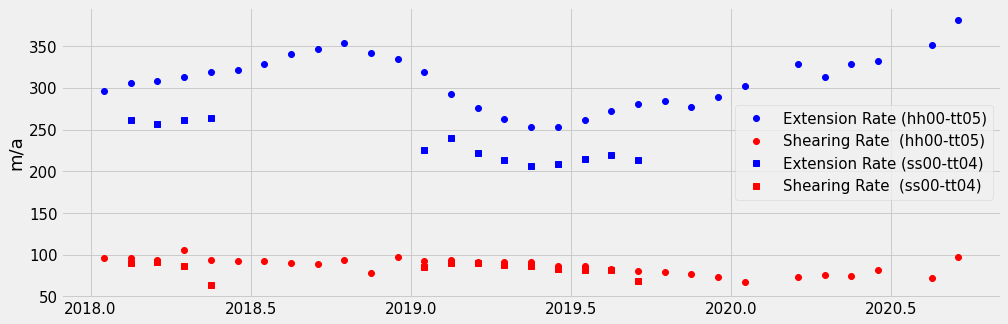

between hh00 and tt05
Mean extension rate: 308.63 m/a
Mean shearing rate: -86.61 m/a
between ss00 and tt04
Mean extension rate: 231.43 m/a
Mean shearing rate: -83.43 m/a
Mean extension rate (hh00-tt05) 2018: 325.81 m/a
Mean extension rate (hh00-tt05) 2019: 276.67 m/a
Mean extension rate (hh00-tt05) 2020: 326.1 m/a
Mean extension rate (ss00-tt04) 2018: 260.73 m/a
Mean extension rate (ss00-tt04) 2019: 218.41 m/a
Mean extension rate (all) 2018: 293.27 m/a
Mean extension rate (all) 2019: 247.54 m/a
Mean extension rate (all) 2020: 293.23 m/a


In [299]:
# Load these now so that we can plot the GPS locations on the map
gps = pd.read_csv(dataset_path + 'bas_marsh_monthly_halloween.csv')

hh00_u = np.array(gps.PSU[ gps.Site=='HH00' ])
hh00_v = np.array(gps.PSV[ gps.Site=='HH00' ])
tt05_u = np.array(gps.PSU[ gps.Site=='TT05' ])
tt05_v = np.array(gps.PSV[ gps.Site=='TT05' ])
ss00_u = np.array(gps.PSU[ gps.Site=='SS00' ])
ss00_v = np.array(gps.PSV[ gps.Site=='SS00' ])
tt04_u = np.array(gps.PSU[ gps.Site=='TT04' ])
tt04_v = np.array(gps.PSV[ gps.Site=='TT04' ])

# throw away a value from tt05_u/v/t
tt05_t_crop = np.delete(tt05_t,[29])
tt05_u_crop = np.delete(tt05_u,[29])
tt05_v_crop = np.delete(tt05_v,[29])

# throw away values from ss00/tt04
ss00_t_crop = np.delete(ss00_t,[4,5,6,7,17])
ss00_u_crop = np.delete(ss00_u,[4,5,6,7,17])
ss00_v_crop = np.delete(ss00_v,[4,5,6,7,17])
tt04_t_crop = np.delete(tt04_t,[0,5,6,16,17,18,19,20,21,22,23,24,25,26])
tt04_u_crop = np.delete(tt04_u,[0,5,6,16,17,18,19,20,21,22,23,24,25,26])
tt04_v_crop = np.delete(tt04_v,[0,5,6,16,17,18,19,20,21,22,23,24,25,26])

# Rotate into rift-coordinates
v1 = np.dot(rot, np.array([hh00_u,hh00_v]))
v2 = np.dot(rot, np.array([tt05_u_crop,tt05_v_crop]))
v3 = np.dot(rot, np.array([ss00_u_crop,ss00_v_crop]))
v4 = np.dot(rot, np.array([tt04_u_crop,tt04_v_crop]))

relative_motion = (v1-v2)*365
relative_motion_ss00_tt04 = (v3-v4)*365
#relative_motion_all = (((v1+v3)/2)-((v2+v4)/2))*365

plt.subplots(figsize=(15,5))
plt.plot(hh00_t,relative_motion[1,:],'o',c='b',label= 'Extension Rate (hh00-tt05)')
plt.plot(hh00_t,-relative_motion[0,:],'o',c='r',label='Shearing Rate  (hh00-tt05)')
plt.plot(ss00_t_crop,relative_motion_ss00_tt04[1,:],'s',c='b',label= 'Extension Rate (ss00-tt04)')
plt.plot(ss00_t_crop,-relative_motion_ss00_tt04[0,:],'s',c='r',label='Shearing Rate  (ss00-tt04)')
plt.legend()
plt.ylabel('m/a')

#plt.savefig('./analyze_annual_gps.png', dpi=300, bbox_inches='tight')
plt.show()

print("between hh00 and tt05")
print("Mean extension rate: "+str(round(np.mean(relative_motion[1,:]),2))+" m/a")
print("Mean shearing rate: "+str(round(np.mean(relative_motion[0,:]),2))+" m/a")
print("between ss00 and tt04")
print("Mean extension rate: "+str(round(np.mean(relative_motion_ss00_tt04[1,:]),2))+" m/a")
print("Mean shearing rate: "+str(round(np.mean(relative_motion_ss00_tt04[0,:]),2))+" m/a")
print("Mean extension rate (hh00-tt05) 2018: "+str(round(np.mean(relative_motion[1,:][0:12]),2))+" m/a")
print("Mean extension rate (hh00-tt05) 2019: "+str(round(np.mean(relative_motion[1,:][12:24]),2))+" m/a")
print("Mean extension rate (hh00-tt05) 2020: "+str(round(np.mean(relative_motion[1,:][24:30]),2))+" m/a")
print("Mean extension rate (ss00-tt04) 2018: "+str(round(np.mean(relative_motion_ss00_tt04[1,:][0:4]),2))+" m/a")
print("Mean extension rate (ss00-tt04) 2019: "+str(round(np.mean(relative_motion_ss00_tt04[1,:][4:13]),2))+" m/a")

print("Mean extension rate (all) 2018: "+str(round(np.mean([round(np.mean(relative_motion[1,:][0:12]),2),round(np.mean(relative_motion_ss00_tt04[1,:][0:4]),2)]),2))+" m/a")
print("Mean extension rate (all) 2019: "+str(round(np.mean([round(np.mean(relative_motion[1,:][12:24]),2),round(np.mean(relative_motion_ss00_tt04[1,:][4:13]),2)]),2))+" m/a")

#factor to convert hh00-tt05 opening to all opening = 0.9

print("Mean extension rate (all) 2020: "+str(round(0.9*np.mean(relative_motion[1,:][0:12]),2))+" m/a")

  

# combine with simple model of rift opening

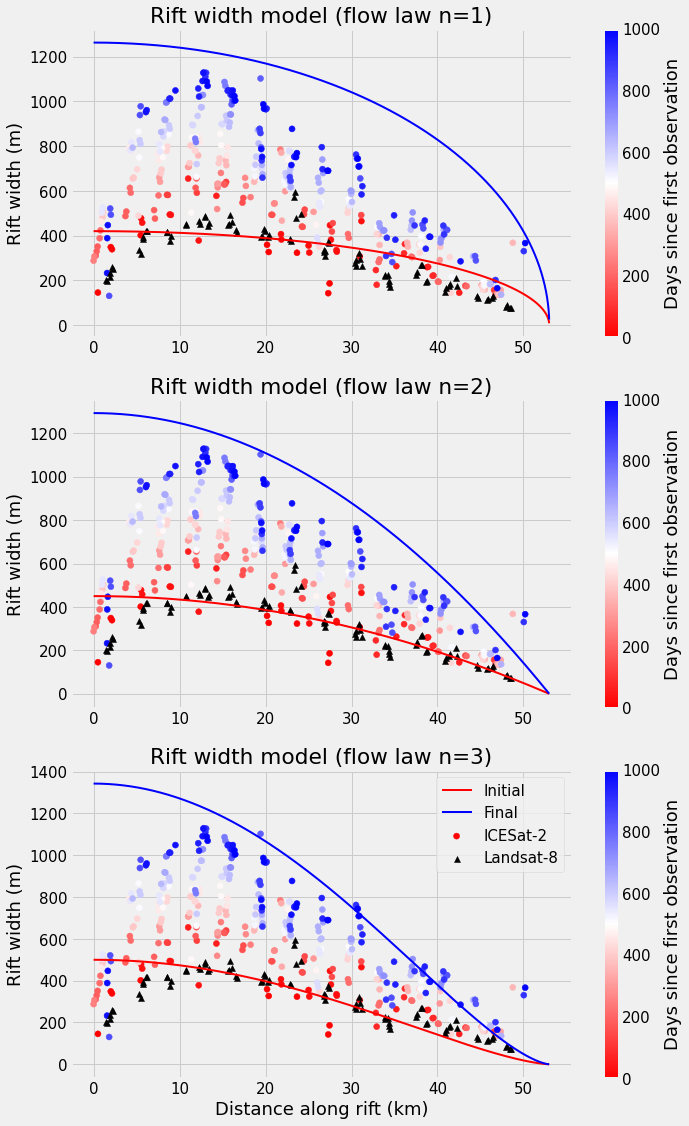

In [300]:
xmin = latest.loc[latest['x'].idxmin()]['x']
ymin = latest.loc[latest['x'].idxmin()]['y']

sat_dist = np.sqrt( (LS8_obs_20181014['x-centroid'].to_numpy()-xmin)**2 + (LS8_obs_20181014['y-centroid'].to_numpy()-ymin)**2 )
sat_width = LS8_obs_20181014["actual-non-iceberg-width"]

dist = np.sqrt( (latest['x'].to_numpy()-xmin)**2 + (latest['y'].to_numpy()-ymin)**2 )

rift_len = 53 #48
xx = np.arange(0,rift_len,0.01)

# rift width simple model at tmax (999 days since first observation)
tmax = max(times)
#rate = 274 / 365 # all gps
rate = 308 / 365 # hh00 and tt05 
wmax = rate * tmax

# rift width at first observation (2014-10-14)
#wmax_init = 450
w_init = [420, 450, 500]

r = np.sqrt(rift_len**2 - xx**2)


fig = plt.subplots(2,1,figsize=(10,18),sharex=True,sharey=True)

for i in (1,2,3):
    ax=plt.subplot(3,1,i)
    n=i
    pl_in = ax.plot(xx,(w_init[n-1] * ((r/rift_len)**n)),'-',linewidth=2,color=(1,0,0),label='Initial')
    pl_sm = ax.plot(xx,(w_init[n-1] * ((r/rift_len)**n)) + (wmax * ((r/rift_len)**n)),'-',linewidth=2,color=(0,0,1),label='Final')

    # plot width including icebergs/peninsulas/bridges
    #pl_c = ax.scatter(dist/1e3,latest['w'],c=times,cmap='bone',vmin=0,vmax=round(tmax,-1),\
    #             alpha=0.5,edgecolors='k',label="ICESat-2") #label=latest['t']

    # plot width ignoring icebergs/peninsulas/bridges
    #pl_is = ax.scatter(dist/1e3,latest['anibw'],c=times,cmap='bone',vmin=0,vmax=round(tmax,-1),\
    #             alpha=0.5,edgecolors='k',label="ICESat-2") #label=latest['t']
    #pl_is = ax.scatter(dist/1e3,latest['anibw'],c=times,cmap='bwr_r',vmin=0,vmax=round(tmax,-1),\
    #             alpha=1,edgecolors='k',label="ICESat-2") #label=latest['t']
    pl_is = ax.scatter(dist/1e3,latest['anibw'],c=times,cmap='bwr_r',vmin=0,vmax=round(tmax,-1),\
                 alpha=1,label="ICESat-2") #label=latest['t'],edgecolors='k'

    cbar=plt.colorbar(pl_is)
    
    # plot Landsat-8 2018-10-14 widths
    pl_ls = ax.scatter(sat_dist/1e3,sat_width,c='k',marker='^',label="Landsat-8")
    
    pl_all =[pl_ls, pl_in, pl_sm, pl_is]
    
    cbar.set_label('Days since first observation')
    ax.set_ylabel('Rift width (m)')
    ax.set_title('Rift width model (flow law n=%d)'%n)
ax.set_xlabel('Distance along rift (km)')    
ax.legend(loc = 'upper right')

#plt.savefig('./analyze_HC_model.png', dpi=300, bbox_inches='tight')
plt.show()

#print('Stretching: %f m over %f days or %f m/y'%(wmax,tmax,rate * 365))
#print('Erosion + stretching: %f m over %f days or %f m/y'%(wmax2,tmax,rate2 * 365))
#print('Erosion is %f %%'%(100*(wmax2-wmax)/wmax2))

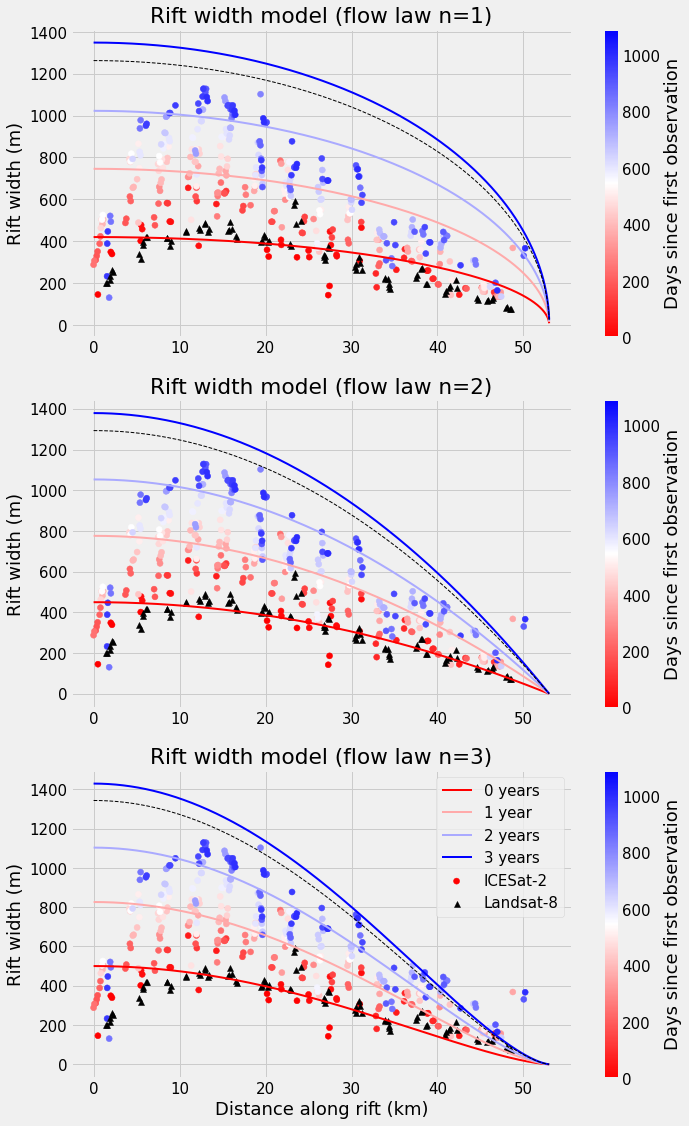

In [301]:
# rift width simple model annually

# overall rate
# 274 m/a using all stations
# 308 m/a using hh00 and tt05 (most data)
# annual opening from hh00 and tt05
# hence factor of (274/308) to simulate annual opening if all gps data available
tmax = max(times)
#rate = 274 / 365 # all gps
rate = 308 / 365 # hh00 and tt05
wmax = rate * tmax

# assuming constant opening 
#t1 = 1*365
#t2 = 2*365
#t3 = 3*365
#w1 = rate * t1
#w2 = rate * t2
#w3 = rate * t3

# assuming time variable opening
# along 215 (326, 277, 326)
# along all (293, 248, 293)
rate1 = 326 #293
rate2 = 277 #248
rate3 = 326 #293
w1 = (rate1/365) * (1*365) 
w2 = ((rate1/365) * (1*365)) + ((rate2/365) * (1*365))
w3 = ((rate1/365) * (1*365)) + ((rate2/365) * (1*365)) + ((rate3/365) * (1*365))


# rift width at first observation (2014-10-14)
#wmax_init = 450
w_init = [420, 450, 500]

r = np.sqrt(rift_len**2 - xx**2)


fig = plt.subplots(2,1,figsize=(10,18),sharex=True,sharey=True)

for i in (1,2,3):
    ax=plt.subplot(3,1,i)
    n=i
    pl_in = ax.plot(xx,(w_init[n-1] * ((r/rift_len)**n)),'-',linewidth=2,color=(1,0,0),label='0 years')
    pl_t1 = ax.plot(xx,(w_init[n-1] * ((r/rift_len)**n)) + (w1 * ((r/rift_len)**n)),'-',linewidth=2,color=(1,2/3,2/3),label='1 year')
    pl_t2 = ax.plot(xx,(w_init[n-1] * ((r/rift_len)**n)) + (w2 * ((r/rift_len)**n)),'-',linewidth=2,color=(2/3,2/3,1),label='2 years')
    pl_t3 = ax.plot(xx,(w_init[n-1] * ((r/rift_len)**n)) + (w3 * ((r/rift_len)**n)),'-',linewidth=2,color=(0,0,1),label='3 years')
    pl_sm = ax.plot(xx,(w_init[n-1] * ((r/rift_len)**n)) + (wmax * ((r/rift_len)**n)),'--',linewidth=1,color=(0,0,0))
    
    # plot width ignoring icebergs/peninsulas/bridges
    pl_is = ax.scatter(dist/1e3,latest['anibw'],c=times,cmap='bwr_r',vmin=0,vmax=3*365,\
                 alpha=1,label="ICESat-2") #label=latest['t'],edgecolors='k'

    cbar=plt.colorbar(pl_is)
    
    # plot Landsat-8 2018-10-14 widths
    pl_ls = ax.scatter(sat_dist/1e3,sat_width,c='k',marker='^',label="Landsat-8")
    
    
    pl_all =[pl_ls, pl_in, pl_t1, pl_t2, pl_t3, pl_is]
    
    #ax.set_xlim(25,35)
    #ax.set_ylim(340,342)
    
    cbar.set_label('Days since first observation')
    ax.set_ylabel('Rift width (m)')
    ax.set_title('Rift width model (flow law n=%d)'%n)
ax.set_xlabel('Distance along rift (km)')
ax.legend(loc = 'upper right')

#plt.savefig('./analyze_HC_model_annual.png', dpi=300, bbox_inches='tight')
plt.show()


## Simple model, tune opening rate to rgt 215(1) and 725(3)
however, it seems like the maximum opening occurs along 215 (the rift isn't fully open near MIR as per model, but there is a second rift tip), therefore, using 215 opening rate as a maximum seems more justified

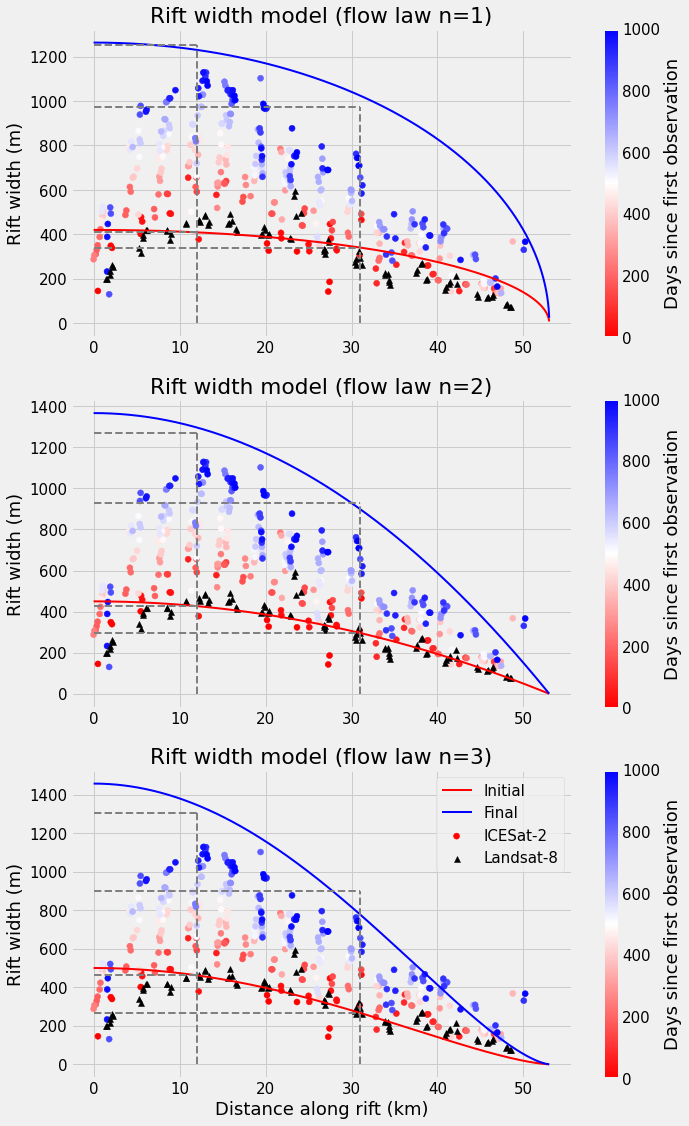

In [302]:
xmin = latest.loc[latest['x'].idxmin()]['x']
ymin = latest.loc[latest['x'].idxmin()]['y']

sat_dist = np.sqrt( (LS8_obs_20181014['x-centroid'].to_numpy()-xmin)**2 + (LS8_obs_20181014['y-centroid'].to_numpy()-ymin)**2 )
sat_width = LS8_obs_20181014["actual-non-iceberg-width"]

dist = np.sqrt( (latest['x'].to_numpy()-xmin)**2 + (latest['y'].to_numpy()-ymin)**2 )

rift_len = 53 #48
xx = np.arange(0,rift_len,0.01)

# rift width simple model at tmax (999 days since first observation)
tmax = max(times)
#rate = 274 / 365 # all gps
#rate = 308 / 365 # hh00 and tt05 
rate = [308/365, 335/365, 350/365]
#wmax = rate * tmax

# rift width at first observation (2014-10-14)
#wmax_init = 450
w_init = [420, 450, 500]

r = np.sqrt(rift_len**2 - xx**2)


fig = plt.subplots(2,1,figsize=(10,18),sharex=True,sharey=True)

for i in (1,2,3):
    
    ax=plt.subplot(3,1,i)
    n=i
    
    wmax = rate[n-1] * tmax
    
    pl_in = ax.plot(xx,(w_init[n-1] * ((r/rift_len)**n)),'-',linewidth=2,color=(1,0,0),label='Initial')
    pl_sm = ax.plot(xx,(w_init[n-1] * ((r/rift_len)**n)) + (wmax * ((r/rift_len)**n)),'-',linewidth=2,color=(0,0,1),label='Final')

    # plot width including icebergs/peninsulas/bridges
    #pl_c = ax.scatter(dist/1e3,latest['w'],c=times,cmap='bone',vmin=0,vmax=round(tmax,-1),\
    #             alpha=0.5,edgecolors='k',label="ICESat-2") #label=latest['t']

    # plot width ignoring icebergs/peninsulas/bridges
    #pl_is = ax.scatter(dist/1e3,latest['anibw'],c=times,cmap='bone',vmin=0,vmax=round(tmax,-1),\
    #             alpha=0.5,edgecolors='k',label="ICESat-2") #label=latest['t']
    #pl_is = ax.scatter(dist/1e3,latest['anibw'],c=times,cmap='bwr_r',vmin=0,vmax=round(tmax,-1),\
    #             alpha=1,edgecolors='k',label="ICESat-2") #label=latest['t']
    pl_is = ax.scatter(dist/1e3,latest['anibw'],c=times,cmap='bwr_r',vmin=0,vmax=round(tmax,-1),\
                 alpha=1,label="ICESat-2") #label=latest['t'],edgecolors='k'

    cbar=plt.colorbar(pl_is)
    
    # plot GPS locations
    init_val1 = [409, 427, 462]
    #ax.plot([12,12],[0,1300],'--',color='0.5',linewidth=2)
    ax.plot([12,12],[0,init_val1[n-1]+(999*308/365)],'--',color='0.5',linewidth=2)
    ax.plot([0,12],[init_val1[n-1],init_val1[n-1]],'--',color='0.5',linewidth=2)
    ax.plot([0,12],[init_val1[n-1]+(999*308/365),init_val1[n-1]+(999*308/365)],'--',color='0.5',linewidth=2)
    
    init_val2 = [340.5, 296, 267]
    #ax.plot([31,31],[0,1300],'--',color='0.5',linewidth=2)
    ax.plot([31,31],[0,init_val2[n-1]+(999*231/365)],'--',color='0.5',linewidth=2)
    ax.plot([0,31],[init_val2[n-1],init_val2[n-1]],'--',color='0.5',linewidth=2)
    ax.plot([0,31],[init_val2[n-1]+(999*231/365),init_val2[n-1]+(999*231/365)],'--',color='0.5',linewidth=2)
    
    
    # plot Landsat-8 2018-10-14 widths
    pl_ls = ax.scatter(sat_dist/1e3,sat_width,c='k',marker='^',label="Landsat-8")
    
    pl_all =[pl_ls, pl_in, pl_sm, pl_is]
    
    #ax.set_xlim(30,32)
    #ax.set_ylim(260,270)
    
    cbar.set_label('Days since first observation')
    ax.set_ylabel('Rift width (m)')
    ax.set_title('Rift width model (flow law n=%d)'%n)
ax.set_xlabel('Distance along rift (km)')    
ax.legend(loc = 'upper right')

#plt.savefig('./analyze_HC_model.png', dpi=300, bbox_inches='tight')
plt.show()

#print('Stretching: %f m over %f days or %f m/y'%(wmax,tmax,rate * 365))
#print('Erosion + stretching: %f m over %f days or %f m/y'%(wmax2,tmax,rate2 * 365))
#print('Erosion is %f %%'%(100*(wmax2-wmax)/wmax2))

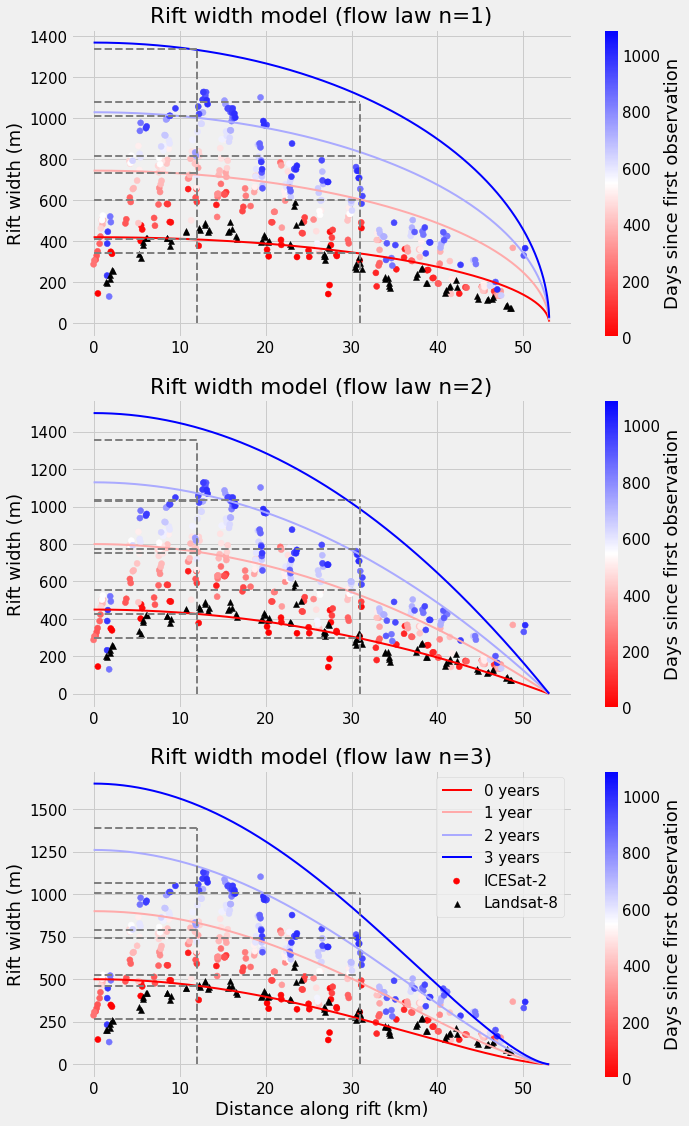

In [303]:
# rift width simple model annually

# overall rate
# 274 m/a using all stations
# 308 m/a using hh00 and tt05 (most data)
# annual opening from hh00 and tt05
# hence factor of (274/308) to simulate annual opening if all gps data available
tmax = max(times)
rate = 274 / 365 # all gps
#rate = 308 / 365 # hh00 and tt05
wmax = rate * tmax

# assuming constant opening 
#t1 = 1*365
#t2 = 2*365
#t3 = 3*365
#w1 = rate * t1
#w2 = rate * t2
#w3 = rate * t3

# assuming time variable opening
rate1 = 293
rate2 = 248
rate3 = 293
w1 = (rate1/365) * (1*365) 
w2 = ((rate1/365) * (1*365)) + ((rate2/365) * (1*365))
w3 = ((rate1/365) * (1*365)) + ((rate2/365) * (1*365)) + ((rate3/365) * (1*365))


# rift width at first observation (2014-10-14)
#wmax_init = 450
w_init = [420, 450, 500]

r = np.sqrt(rift_len**2 - xx**2)


fig = plt.subplots(2,1,figsize=(10,18),sharex=True,sharey=True)

for i in (1,2,3):
    ax=plt.subplot(3,1,i)
    n=i
    
    #w1 = [293, 293, 293]
    #w2 = [293+248, 293+248, 293+248]
    #w3 = [293+248+293, 293+248+293, 293+248+293]
    w1 = [325, 350, 400]
    w2 = [610, 680, 760]
    w3 = [950, 1050, 1150]
    
    pl_in = ax.plot(xx,(w_init[n-1] * ((r/rift_len)**n)),'-',linewidth=2,color=(1,0,0),label='0 years')
    pl_t1 = ax.plot(xx,(w_init[n-1] * ((r/rift_len)**n)) + (w1[n-1] * ((r/rift_len)**n)),'-',linewidth=2,color=(1,2/3,2/3),label='1 year')
    pl_t2 = ax.plot(xx,(w_init[n-1] * ((r/rift_len)**n)) + (w2[n-1] * ((r/rift_len)**n)),'-',linewidth=2,color=(2/3,2/3,1),label='2 years')
    pl_t3 = ax.plot(xx,(w_init[n-1] * ((r/rift_len)**n)) + (w3[n-1] * ((r/rift_len)**n)),'-',linewidth=2,color=(0,0,1),label='3 years')
    #pl_sm = ax.plot(xx,(w_init[n-1] * ((r/rift_len)**n)) + (wmax * ((r/rift_len)**n)),'--',linewidth=1,color=(0,0,0))
    
    # plot width ignoring icebergs/peninsulas/bridges
    pl_is = ax.scatter(dist/1e3,latest['anibw'],c=times,cmap='bwr_r',vmin=0,vmax=3*365,\
                 alpha=1,label="ICESat-2") #label=latest['t'],edgecolors='k'

    cbar=plt.colorbar(pl_is)
    
    # plot Landsat-8 2018-10-14 widths
    pl_ls = ax.scatter(sat_dist/1e3,sat_width,c='k',marker='^',label="Landsat-8")
    
    # plot GPS locations
    # rgt 2018 2019 2020
    # 215 326  277  326
    # 725 260  218  260
    init_val1 = [409, 427, 462]
    ax.plot([12,12],[0,init_val1[n-1]+(326+277+326)],'--',color='0.5',linewidth=2)
    ax.plot([0,12],[init_val1[n-1],init_val1[n-1]],'--',color='0.5',linewidth=2)
    ax.plot([0,12],[init_val1[n-1]+(326),init_val1[n-1]+(326)],'--',color='0.5',linewidth=2)
    ax.plot([0,12],[init_val1[n-1]+(326+277),init_val1[n-1]+(326+277)],'--',color='0.5',linewidth=2)
    ax.plot([0,12],[init_val1[n-1]+(326+277+326),init_val1[n-1]+(326+277+326)],'--',color='0.5',linewidth=2)
    
    init_val2 = [340.5, 296, 267]
    ax.plot([31,31],[0,init_val2[n-1]+(260+218+260)],'--',color='0.5',linewidth=2)
    ax.plot([0,31],[init_val2[n-1],init_val2[n-1]],'--',color='0.5',linewidth=2)
    ax.plot([0,31],[init_val2[n-1]+(260),init_val2[n-1]+(260)],'--',color='0.5',linewidth=2)
    ax.plot([0,31],[init_val2[n-1]+(260+218),init_val2[n-1]+(260+218)],'--',color='0.5',linewidth=2)
    ax.plot([0,31],[init_val2[n-1]+(260+218+260),init_val2[n-1]+(260+218+260)],'--',color='0.5',linewidth=2)
    
    pl_all =[pl_ls, pl_in, pl_t1, pl_t2, pl_t3, pl_is]
    
    #ax.set_xlim(25,35)
    #ax.set_ylim(340,342)
    
    cbar.set_label('Days since first observation')
    ax.set_ylabel('Rift width (m)')
    ax.set_title('Rift width model (flow law n=%d)'%n)
ax.set_xlabel('Distance along rift (km)')
ax.legend(loc = 'upper right')

#plt.savefig('./analyze_HC_model_annual.png', dpi=300, bbox_inches='tight')
plt.show()


## Seaward-landward offset

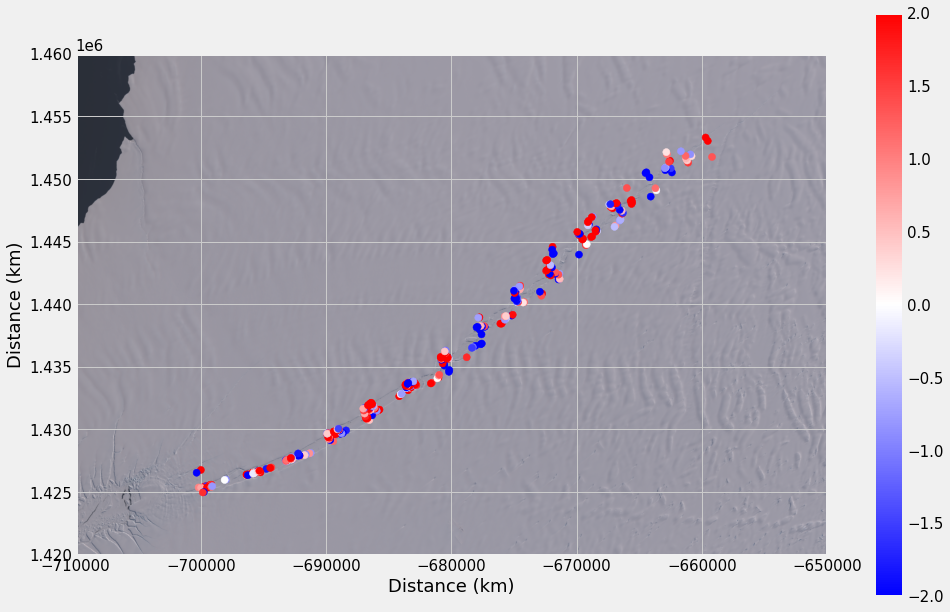

In [319]:
# This is a good window for the Halloween Crack
window_x_halloween = [-7.3e5,-6.4e5]
window_y_halloween = [1.35e6,1.46e6]

fig,axs=plt.subplots(figsize=(15,10))

#image file
satellite_path = '/home/ram21/notebooks/brunt-is2-rifts/halloween/'
satellite_name = 'LC08_L1GT_183114_20200128_20201016_02_T2'

landsat_B4_name = satellite_path+'landsat/'+satellite_name+'/'+satellite_name+'_B4.TIF'
landsat_B3_name = satellite_path+'landsat/'+satellite_name+'/'+satellite_name+'_B3.TIF'
landsat_B2_name = satellite_path+'landsat/'+satellite_name+'/'+satellite_name+'_B2.TIF'

band4 = rasterio.open(landsat_B4_name)
band3 = rasterio.open(landsat_B3_name)
band2 = rasterio.open(landsat_B2_name)

band2_geo = band2.profile
band2_geo.update({"count": 3})

with rasterio.open('rgb.tiff', 'w', **band2_geo) as dest:
    dest.write(band2.read(1),1)
    dest.write(band3.read(1),2)
    dest.write(band4.read(1),3)

img = rasterio.open('rgb.tiff')
image = np.array([img.read(3), img.read(2), img.read(1)]).transpose(1,2,0)
L8_to_plot = (image * (255 / np.max(image))).astype(np.uint8)
        
show(L8_to_plot.transpose(2,0,1), transform=img.transform,ax=axs)

# scatter
pl_sl = axs.scatter(halloween_obs_merged['x-centroid'] ,halloween_obs_merged['y-centroid'] ,s=50,\
            c=halloween_obs_merged['sl_offset'],cmap='bwr',vmin=-2,vmax=2) #,alpha=0.5)
cbar=plt.colorbar(pl_sl)
axs.set_xlabel('Distance (km)')
axs.set_ylabel('Distance (km)')
axs.set_xlim(-710000,-650000)
axs.set_ylim(1420000,1460000)

#plt.savefig('./analyze_sl_offset.png', dpi=300, bbox_inches='tight')
plt.show()